In [1]:
import os
import tempfile

# data
import pandas as pd
from datasetsforecast.m4 import M4, M4Evaluation, M4Info
from utilsforecast.plotting import plot_series

# feature engine
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean

# forecast
from mlforecast import MLForecast
from sklearn.pipeline import make_pipeline

# models
import lightgbm as lgb
from sklearn.linear_model import Ridge
from mlforecast.auto import (
    AutoMLForecast,
    AutoModel,
    AutoLightGBM,
    AutoRidge,
    ridge_space,
)

# model tune
import optuna

# data

In [2]:
# def get_data(group, horizon):
#     M4.async_download(directory = "data")
#     df, *_ = M4.load(directory = "data", group = group)
#     df["ds"] = df["ds"].astype("int")
#     df["unique_id"] = df["unique_id"].astype("category")

#     return df.groupby("unique_id").head(-horizon).copy()

# group = "Hourly"
# horizon = M4Info[group].horizon
# train = get_data(group, horizon)

horizon = M4Info["Hourly"].horizon

def load_data(horizon = horizon):
    """
    data read and filter
    """
    # data read
    df = pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")
    # data filter
    df['ds'] = df['ds'].astype('int')
    df["unique_id"] = df["unique_id"].astype("category")
    df.groupby("unique_id").head(-horizon).copy()
    
    return df

train = load_data()

print(train.head())
print()
print(train.shape)
print()
print(train["unique_id"].value_counts())

  unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

(373372, 3)

unique_id
H286    1008
H283    1008
H290    1008
H289    1008
H288    1008
        ... 
H163     748
H164     748
H165     748
H166     748
H99      748
Name: count, Length: 414, dtype: int64


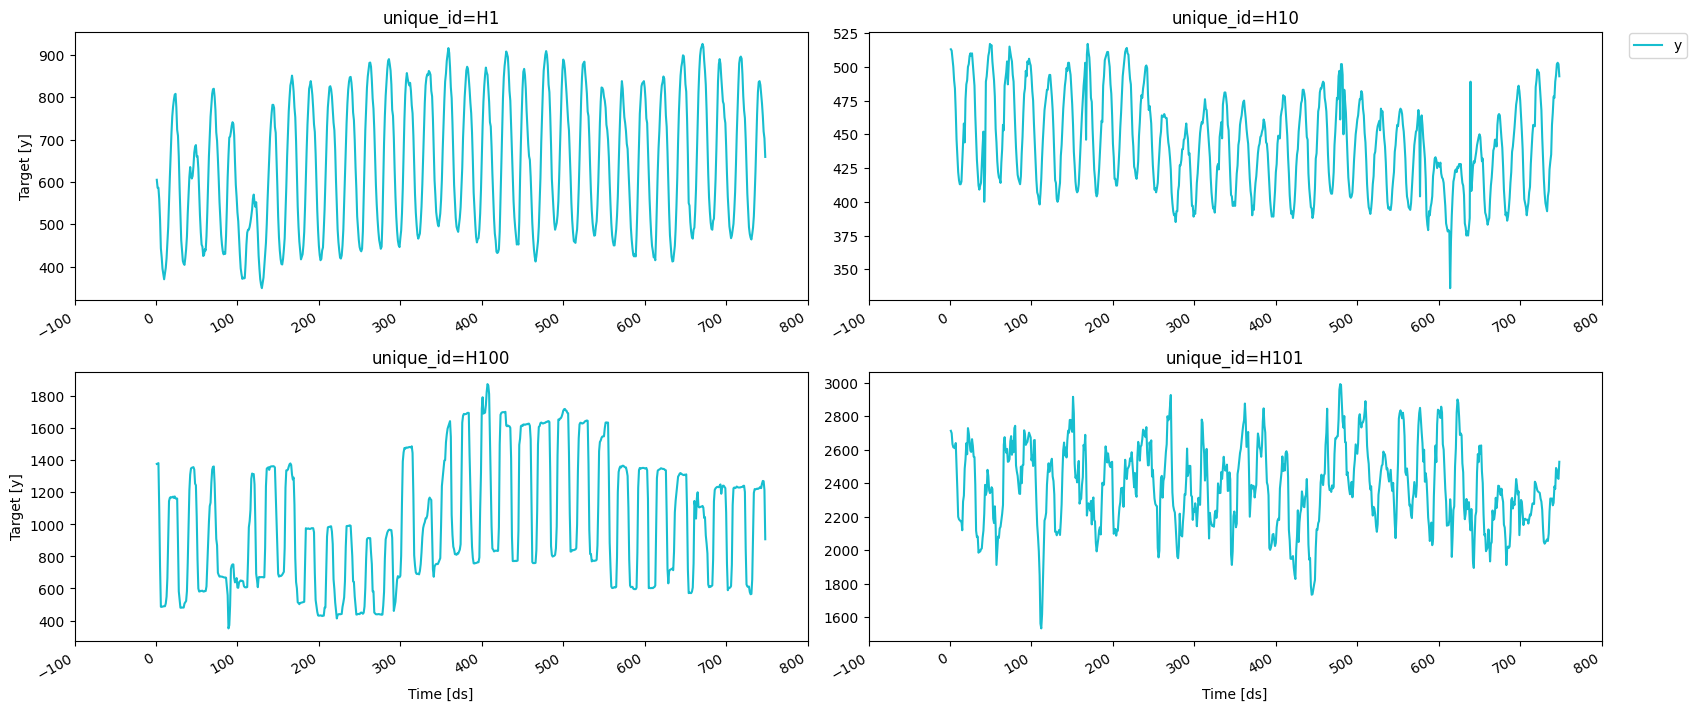

In [3]:
fig = plot_series(train, max_ids = 4, plot_random=False)
fig

# optuna config

In [4]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

# model default optimization

## model

In [5]:
auto_mlf = AutoMLForecast(
    models = {
        "lgb": AutoLightGBM(),
        "ridge": AutoRidge(),
    },
    freq = 1,
    season_length = 24,
)

## training

In [6]:
auto_mlf.fit(
    train,
    n_windows = 2,
    h = horizon,
    num_samples = 2,  # number of trials to run
)

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'ridge': AutoModel(model=Ridge)})

## forecasting

In [7]:
preds = auto_mlf.predict(horizon)

print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id   ds         lgb       ridge
0        H1  749  640.601986  589.385276
1        H1  750  606.712435  525.486698
2        H1  751  582.144179  483.245910
3        H1  752  550.502810  445.156419
4        H1  753  545.655853  427.016670

(19872, 4)

unique_id
H1      48
H344    48
H353    48
H352    48
H351    48
        ..
H220    48
H22     48
H219    48
H218    48
H99     48
Name: count, Length: 414, dtype: int64


## evaluate

In [8]:
def evaluate(df, group, horizon):
    results = []
    for model_name in df.columns.drop(["unique_id", "ds"]):
        model_res = M4Evaluation.evaluate(
            directory = "data", 
            group = group,
            y_hat = df[model_name].to_numpy().reshape(-1, horizon)
        )
        model_res.index = [model_name]
        results.append(model_res)

    return pd.concat(results).T.round(2)


evaluate(df = preds, group = "Hourly", horizon = horizon)

,lgb,ridge
SMAPE,11.73,18.34
MASE,5.12,1.56
OWA,1.39,0.82


## optimization results

In [12]:
auto_mlf.models_

{'lgb': MLForecast(models=[lgb], freq=1, lag_features=['lag48', 'exponentially_weighted_mean_lag1_alpha0.9'], date_features=[], num_threads=1),
 'ridge': MLForecast(models=[ridge], freq=1, lag_features=['lag24', 'lag48', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag24_window_size24_min_samples1', 'rolling_mean_lag48_window_size24_min_samples1'], date_features=[], num_threads=1)}

In [10]:
auto_mlf.results_["lgb"].best_trial.user_attrs["config"]

{'model_params': {'bagging_freq': 1,
  'learning_rate': 0.05,
  'verbosity': -1,
  'n_estimators': 169,
  'lambda_l1': 0.027334069690310565,
  'lambda_l2': 0.0026599310838681858,
  'num_leaves': 112,
  'feature_fraction': 0.7118273996694524,
  'bagging_fraction': 0.8229470565333281,
  'objective': 'l2'},
 'mlf_init_params': {'lags': [48],
  'target_transforms': None,
  'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)]},
  'date_features': None,
  'num_threads': 1},
 'mlf_fit_params': {}}

In [11]:
auto_mlf.results_["ridge"].best_trial.user_attrs["config"]

{'model_params': {'fit_intercept': False, 'alpha': 0.39283873475095243},
 'mlf_init_params': {'lags': [24, 48],
  'target_transforms': [<mlforecast.target_transforms.Differences at 0x1f740e04d60>,
  'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)],
   24: [RollingMean(min_samples=1, window_size=24)],
   48: [RollingMean(min_samples=1, window_size=24)]},
  'date_features': None,
  'num_threads': 1},
 'mlf_fit_params': {}}

# tuning model parameters

## model

In [45]:
def my_lgb_config(trial: optuna.Trial):
    return {
        "learning_rate": 0.05,
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 128, log = True),
        "objective": trial.suggest_categorical("objective", ["l1", "l2", "mape"])
    }


auto_mlf = AutoMLForecast(
    models = {
        "my_lgb": AutoModel(model = lgb.LGBMRegressor(), config = my_lgb_config)
    },
    freq = 1,
    season_length = 24,
)

## training

In [46]:
auto_mlf.fit(
    train,
    n_windows = 2,
    h = horizon,
    num_samples = 2,
)

AutoMLForecast(models={'my_lgb': AutoModel(model=LGBMRegressor)})

## forecasting

In [47]:
preds = auto_mlf.predict(h = horizon)

print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id   ds      my_lgb
0        H1  749  630.071643
1        H1  750  590.635550
2        H1  751  551.207484
3        H1  752  521.585568
4        H1  753  499.764715

(19872, 3)

unique_id
H1      48
H344    48
H353    48
H352    48
H351    48
        ..
H220    48
H22     48
H219    48
H218    48
H99     48
Name: count, Length: 414, dtype: int64


## evaluate

In [48]:
evaluate(df = preds, group = "Hourly", horizon = horizon)

,my_lgb
SMAPE,12.54
MASE,4.28
OWA,1.24


## optimization results

In [49]:
auto_mlf.models_

{'my_lgb': MLForecast(models=[my_lgb], freq=1, lag_features=['lag48', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag24_window_size24_min_samples1'], date_features=[], num_threads=1)}

In [50]:
auto_mlf.results_["my_lgb"].best_trial.user_attrs["config"]

{'model_params': {'learning_rate': 0.05,
  'verbosity': -1,
  'num_leaves': 12,
  'objective': 'l1'},
 'mlf_init_params': {'lags': [48],
  'target_transforms': [<mlforecast.target_transforms.LocalStandardScaler at 0x1f740e777f0>],
  'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)],
   24: [RollingMean(min_samples=1, window_size=24)]},
  'date_features': None,
  'num_threads': 1},
 'mlf_fit_params': {}}

## sklearn pipeline

In [25]:
ridge_pipeline = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("encoder", OneHotEncoder(), ["unique_id"])
        ],
        remainder = "passthrough",
    ),
    Ridge(),
)

auto_mlf = AutoMLForecast(
    models = {
        "ridge": AutoModel(
            model = ridge_pipeline,
            config = lambda trial: {f"ridge__{k}": v for k, v in ridge_space(trial).items()}
        ),
    },
    freq = 1,
    season_length = 24,
    fit_config = lambda trial: {"static_features": ["unique_id"]}
)

In [26]:
auto_mlf.fit(
    train,
    n_windows = 2,
    h = horizon,
    num_samples = 2,
)

AutoMLForecast(models={'ridge': AutoModel(model=Ridge)})

In [27]:
preds = auto_mlf.predict(horizon)

print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id   ds       ridge
0        H1  749  592.867370
1        H1  750  528.045230
2        H1  751  488.477485
3        H1  752  451.206502
4        H1  753  432.237244

(19872, 3)

unique_id
H1      48
H344    48
H353    48
H352    48
H351    48
        ..
H220    48
H22     48
H219    48
H218    48
H99     48
Name: count, Length: 414, dtype: int64


In [28]:
evaluate(preds, group = "Hourly", horizon = horizon)

,ridge
SMAPE,16.67
MASE,1.53
OWA,0.77


In [29]:
auto_mlf.models_

{'ridge': MLForecast(models=[ridge], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag24_window_size24_min_samples1', 'rolling_mean_lag48_window_size24_min_samples1'], date_features=[], num_threads=1)}

In [30]:
auto_mlf.results_["ridge"].best_trial.user_attrs["config"]

{'model_params': {'ridge__fit_intercept': False,
  'ridge__alpha': 6.028030997340368},
 'mlf_init_params': {'lags': range(24, 169, 24),
  'target_transforms': [<mlforecast.target_transforms.Differences at 0x1f740ba1970>,
  'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)],
   24: [RollingMean(min_samples=1, window_size=24)],
   48: [RollingMean(min_samples=1, window_size=24)]},
  'date_features': None,
  'num_threads': 1},
 'mlf_fit_params': {'static_features': ['unique_id']}}

# tuning features

## model

In [33]:
def my_init_config(trial: optuna.Trial):
    lag_transforms = [
        ExponentiallyWeightedMean(alpha=0.3),
        RollingMean(window_size=24 * 7, min_samples=1),
    ]
    lag_to_transform = trial.suggest_categorical('lag_to_transform', [24, 48])
    return {
        'lags': [24 * i for i in range(1, 7)],  # this won't be tuned
        'lag_transforms': {lag_to_transform: lag_transforms},
    }

auto_mlf = AutoMLForecast(
    models=[AutoRidge()],
    freq=1,
    # season_length=24,
    init_config=my_init_config,
)

## training

In [34]:
auto_mlf.fit(
    train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

AutoMLForecast(models={'AutoRidge': AutoModel(model=Ridge)})

## forecasting

In [35]:
preds = auto_mlf.predict(horizon)

print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id   ds   AutoRidge
0        H1  749  674.710021
1        H1  750  601.187333
2        H1  751  555.590394
3        H1  752  514.231899
4        H1  753  490.790859

(19872, 3)

unique_id
H1      48
H344    48
H353    48
H352    48
H351    48
        ..
H220    48
H22     48
H219    48
H218    48
H99     48
Name: count, Length: 414, dtype: int64


## evaluate

In [36]:
evaluate(preds, group = "Hourly", horizon = horizon)

,AutoRidge
SMAPE,13.70
MASE,1.65
OWA,0.72


# tuning fit parameters

## model

In [37]:
def my_fit_config(trial: optuna.Trial):
    if trial.suggest_int('use_id', 0, 1):
        static_features = ['unique_id']
    else:
        static_features = None
    return {
        'static_features': static_features
    }

auto_mlf = AutoMLForecast(
    models=[AutoLightGBM()],
    freq=1,
    season_length=24,
    fit_config=my_fit_config,
)

## training

In [38]:
auto_mlf.fit(
    train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

AutoMLForecast(models={'AutoLightGBM': AutoModel(model=LGBMRegressor)})

## forecasting

In [41]:
preds = auto_mlf.predict(horizon)

print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id   ds  AutoLightGBM
0        H1  749    640.601986
1        H1  750    606.712435
2        H1  751    582.144179
3        H1  752    550.502810
4        H1  753    545.655853

(19872, 3)

unique_id
H1      48
H344    48
H353    48
H352    48
H351    48
        ..
H220    48
H22     48
H219    48
H218    48
H99     48
Name: count, Length: 414, dtype: int64


## evaluate

In [40]:
evaluate(preds, group = "Hourly", horizon = horizon)

,AutoLightGBM
SMAPE,11.73
MASE,5.12
OWA,1.39


# optimization results

In [42]:
auto_mlf.results_["AutoLightGBM"].best_trial.user_attrs["config"]

{'model_params': {'bagging_freq': 1,
  'learning_rate': 0.05,
  'verbosity': -1,
  'n_estimators': 169,
  'lambda_l1': 0.027334069690310565,
  'lambda_l2': 0.0026599310838681858,
  'num_leaves': 112,
  'feature_fraction': 0.7118273996694524,
  'bagging_fraction': 0.8229470565333281,
  'objective': 'l2'},
 'mlf_init_params': {'lags': [48],
  'target_transforms': None,
  'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)]},
  'date_features': None,
  'num_threads': 1},
 'mlf_fit_params': {'static_features': None}}

In [43]:
auto_mlf.models_

{'AutoLightGBM': MLForecast(models=[AutoLightGBM], freq=1, lag_features=['lag48', 'exponentially_weighted_mean_lag1_alpha0.9'], date_features=[], num_threads=1)}

# saving

In [44]:
with tempfile.TemporaryDirectory() as tmpdir:
    auto_mlf.save(tmpdir)
    print(os.listdir(tmpdir))
    loaded = MLForecast.load(f"{tmpdir}/AutoLightGBM")
    print(loaded)

['AutoLightGBM']
MLForecast(models=[AutoLightGBM], freq=1, lag_features=['lag48', 'exponentially_weighted_mean_lag1_alpha0.9'], date_features=[], num_threads=1)
